# Exploring interpolation

## 1D interpolation

### Linear interpolation

First lets try making a 1D linear interpolator, then lets compare to the `interp1d` function from Scipy.

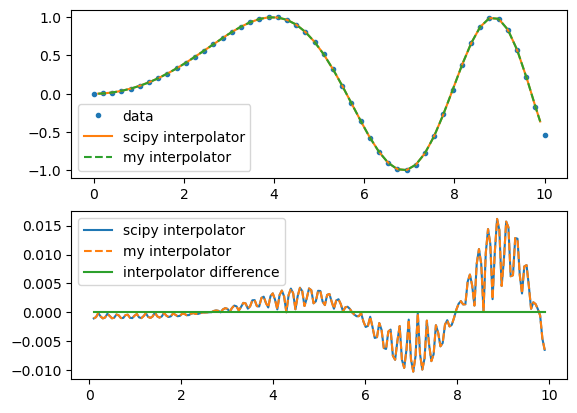

In [2]:
import numpy as np
import math
from numba import jit
from scipy.interpolate import interp1d
from matplotlib import pyplot as plt

# Define function that we want to interpolate
fnc = lambda x: np.sin(0.1*x**2)

# Generate points
x = np.linspace(0,10,50)
y = fnc(x)

# Create scipy interpolator
sfnc = interp1d(x, y)

# Create custom interpolator
dx = np.diff(x)[0]
@jit(nopython=True)
def jinterp(xvals):
    yvals = np.full_like(xvals, np.nan)
    for i in range(len(xvals)):
        ix = int(math.floor(xvals[i]/dx))
        t = (xvals[i] - dx*ix)/(dx*(ix+1)-dx*ix)
        yvals[i] = t*y[ix+1] + (1-t)*y[ix]
    return yvals

# Use interpolators
xinterp = np.linspace(0.1,9.9,200)

# Plot
fig, [ax0,ax1] = plt.subplots(nrows=2)
ax0.plot(x,y,'.',label='data')
ax0.plot(xinterp, sfnc(xinterp),label='scipy interpolator')
ax0.plot(xinterp, jinterp(xinterp), '--',label='my interpolator')
ax0.legend()

ax1.plot(xinterp, fnc(xinterp) - sfnc(xinterp), label='scipy interpolator')
ax1.plot(xinterp, fnc(xinterp) - jinterp(xinterp), '--', label='my interpolator')
ax1.plot(xinterp, sfnc(xinterp) - jinterp(xinterp), label='interpolator difference')
ax1.legend()

plt.show()

My interpolator seems to be equivalent. Lets try a speed test.

In [3]:
%timeit sfnc(xinterp)

5.07 μs ± 94.6 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [4]:
%timeit jinterp(xinterp)

602 ns ± 6.36 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)


In [5]:
%timeit np.interp(xinterp, x, y)

1.52 μs ± 15.3 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)


Mine is fastest.

Now lets look at the error of the interpolator at each point in the case of this function.

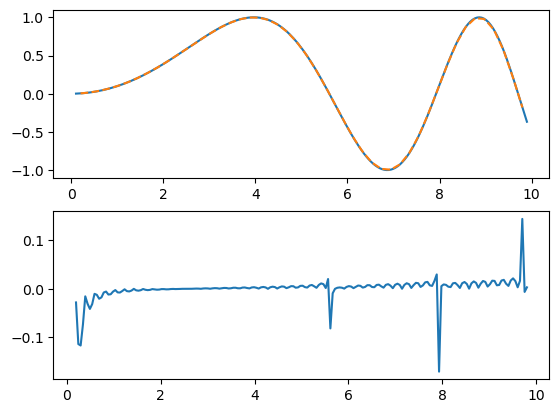

In [6]:
fig, [ax0,ax1] = plt.subplots(nrows=2)
ax0.plot(xinterp, fnc(xinterp))
ax0.plot(xinterp[2:-2], jinterp(xinterp[2:-2]),'--')
ax1.plot(xinterp[2:-2], (fnc(xinterp[2:-2]) - jinterp(xinterp[2:-2]))/fnc(xinterp[2:-2]))
plt.show()

The relative error can get as high as 15%! That is quite large. Lets now try this with a scipy spline interpolator.

### Cubic spline interpolator

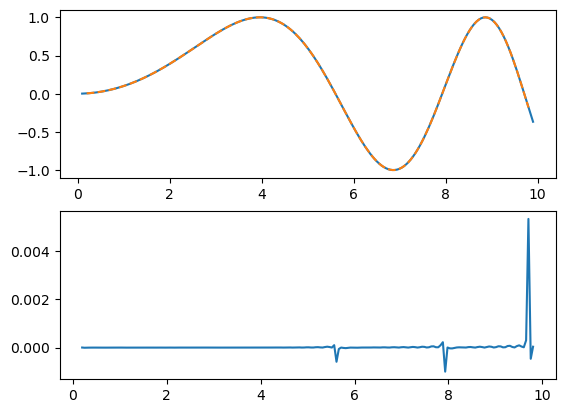

In [7]:
from scipy.interpolate import CubicSpline

csfnc = CubicSpline(x, y)

fig, [ax0,ax1] = plt.subplots(nrows=2)
ax0.plot(xinterp, fnc(xinterp))
ax0.plot(xinterp[2:-2], csfnc(xinterp[2:-2]),'--')
ax1.plot(xinterp[2:-2], (fnc(xinterp[2:-2]) - csfnc(xinterp[2:-2]))/fnc(xinterp[2:-2]))
plt.show()

Much lower error, only 0.5% at most.

In [8]:
%timeit csfnc(xinterp)

3.31 μs ± 14.6 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


Slower than my linear interpolator, but probably much better!

## Interpolation in higher dimensions

Lets define a complicated function to interpolate.

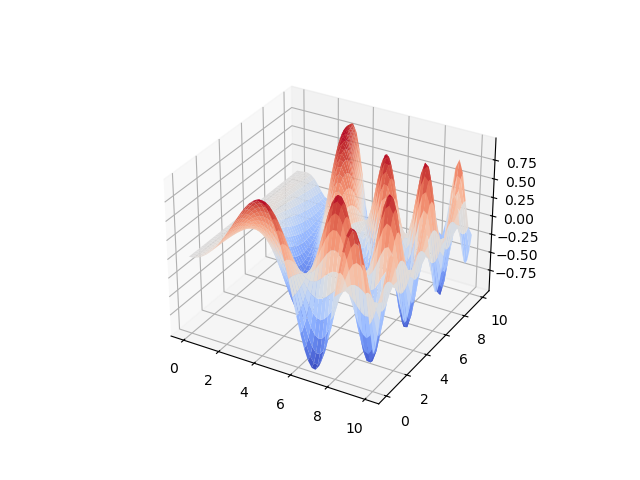

In [9]:
# Define function that we want to interpolate
fnc = lambda x,y: np.sin(0.1*x**2)*np.cos(0.2*y*x)

# Define function that we want to interpolate (this is the Ackley function)
#fnc = lambda x,y: -20*np.exp(-0.2*np.sqrt(0.5*(x**2+y**2)))-np.exp(0.5*(np.cos(2*np.pi*x)+np.cos(2*np.pi*y)))+np.e+20

# Generate points
x = np.linspace(0,10,50)
y = np.linspace(0,10,50)
X, Y = np.meshgrid(x,y)
z = fnc(X,Y)

# Plot
%matplotlib widget

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.plot_surface(X, Y, z, cmap='coolwarm')
plt.show()

%matplotlib inline

### Testing `RegularGridInterpolator`

In [ ]:
from scipy.interpolate import RegularGridInterpolator

# Create interpolators
rgil = RegularGridInterpolator((x, y), z, method='linear')
rgic = RegularGridInterpolator((x, y), z, method='cubic')

# Use interpolators
xinterp = np.linspace(0.1,9.9,200)
yinterp = np.linspace(0.1,9.9,200)
Xinterp, Yinterp = np.meshgrid(xinterp,yinterp)

# Plot
%matplotlib widget

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.plot_surface(Xinterp, Yinterp, fnc(Xinterp,Yinterp)-rgil((Yinterp,Xinterp)), cmap='coolwarm')
plt.title('linear')
plt.show()

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.plot_surface(Xinterp, Yinterp, fnc(Xinterp,Yinterp)-rgic((Yinterp,Xinterp)), cmap='coolwarm')
plt.title('cubic')
plt.show()

%matplotlib inline

Lets time the functions

In [ ]:
%timeit rgil((Yinterp,Xinterp))

In [ ]:
%timeit rgic((Yinterp,Xinterp))

This is getting very slow... What if we just need a single point?

In [ ]:
%timeit rgic([0.345,0.283])

Faster than a direct call to `gbragg`, which is 4.31ms.

### Testing `interpn`

In [ ]:
from scipy.interpolate import interpn

# Use interpolators
xinterp = np.linspace(0.1,9.9,200)
yinterp = np.linspace(0.1,9.9,200)
Xinterp, Yinterp = np.meshgrid(xinterp,yinterp)

# Plot
%matplotlib widget

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.plot_surface(Xinterp, Yinterp, fnc(Xinterp,Yinterp)-interpn((x, y), z, (Yinterp,Xinterp), method='linear'), cmap='coolwarm')
plt.title('linear')
plt.show()

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.plot_surface(Xinterp, Yinterp, fnc(Xinterp,Yinterp)-interpn((x, y), z, (Yinterp,Xinterp), method='cubic'), cmap='coolwarm')
plt.title('cubic')
plt.show()

%matplotlib inline

Lets time the functions

In [ ]:
%timeit interpn((x, y), z, (Yinterp,Xinterp), method='linear')

In [ ]:
%timeit interpn((x, y), z, (Yinterp,Xinterp), method='cubic')

This is getting very slow... What if we just need a single point?

In [ ]:
%timeit interpn((x, y), z, [0.345,0.283], method='cubic')

Marginally faster than a direct call to `gbragg`, which is 4.31ms. Notably slower than `RegularGridInterpolator`, since I think `interpn` has to solve the spline matrix equation for each call rather than just once.

## Next steps

I might be able to gain some speed if I make my own implementation of `RegularGridInterpolator` for cubic splines and use `numba` to speed things up.

Useful resources for this:
- Chapter 5 of *The Elements of Statistical Learning*
- Chapter 3.3 of *Numerical Recipes*

## Sample interpolation

Interpolation of gbragg

In [4]:
import numpy as np
from mwave.interpolation import convergend
from mwave.integrate import gbragg, make_kvec, make_phi

# Define parameters
sigma = 40e-6*2066*2*np.pi
tfinal = 10*sigma
kvec, _, _ = make_kvec(0, 7)
phi0 = make_phi(kvec, n0=0)

# Define a grid
pvals = np.linspace(0,10,5)
dvals = np.arange(2, 25).astype(float)

# Define interpolation function
def fnc(args):
    omega, delta = args
    out = np.empty((len(omega), len(delta), len(kvec)), dtype=np.complex128)
    for i in range(len(omega)):
        for j in range(len(delta)):
            sol = gbragg(kvec, phi0, tfinal, delta[j], omega[i], sigma)
            out[i,j,:] = sol.y[:,-1]
    return out

# Use converge1d to create an accurate interpolator for the function
xgrid, ygrid, ifnc = convergend(fnc, (pvals, dvals), verbosity=2, atol=5e-3, rtol=10, atolfrac=0.01)

# Create a meshgrid so that we can compute using the interpolation function
args_grid = np.meshgrid(*xgrid, indexing='ij')

Computing grid on [9, 45] points.
Interpolating a coarse grid of [5, 23] points to a fine grid of [9, 45] points results in 183/2464 absolute errors and 0/2464 relative errors.
Computing grid on [17, 89] points.
Interpolating a coarse grid of [9, 45] points to a fine grid of [17, 89] points results in 422/9856 absolute errors and 0/9856 relative errors.
Computing grid on [33, 177] points.
Interpolating a coarse grid of [17, 89] points to a fine grid of [33, 177] points results in 457/39424 absolute errors and 0/39424 relative errors.
Computing grid on [65, 353] points.
Interpolating a coarse grid of [33, 177] points to a fine grid of [65, 353] points results in no absolute or relative errors.


Computing grid on 99 points.
Interpolating a coarse grid of 50 points to a fine grid of 99 points results in 101 absolute errors and 0 relative errors.
Computing grid on 197 points.
Interpolating a coarse grid of 99 points to a fine grid of 197 points results in 5 absolute errors and 0 relative errors.
Computing grid on 203 points.
Interpolating a coarse grid of 102 points to a fine grid of 203 points results in no absolute or relative errors.


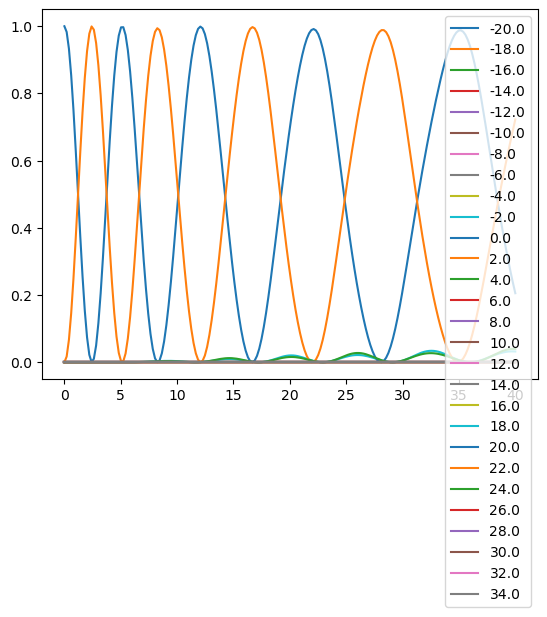

In [6]:
import numpy as np
from mwave.interpolation import converge1d
from mwave.integrate import gbragg, make_kvec, make_phi
from matplotlib import pyplot as plt

# Define parameters
sigma = 40e-6*2066*2*np.pi
tfinal = 10*sigma
kvec, _, _ = make_kvec(0, 7)
phi0 = make_phi(kvec, n0=0)
delta = 4

# Define a grid
omegas = np.linspace(0,40,50)

# Define interpolation function
def fnc(omegas):
    out = np.full((len(omegas), len(kvec)), np.nan, dtype=np.complex128)
    phi0 = make_phi(kvec, n0=0)
    for i in range(len(omegas)):
        sol = gbragg(kvec, phi0, tfinal, delta, omegas[i], sigma)
        out[i,:] = sol.y[:,-1]
    return out

# Use converge1d to create an accurate interpolator for the function
xgrid, ygrid, ifnc = converge1d(fnc, omegas, divideall=False, verbosity=2, atol=1e-4, rtol=2.1)

plt.plot(np.linspace(0, 40, 200), np.abs(ifnc(np.linspace(0, 40, 200)))**2, label=kvec)
plt.legend()
plt.show()

## Data chunking and convergence testing

Please see the `mwave.interpolate` module!

Lets define a funky function to interpolate:

In [ ]:
import inspect

class ParameterSpace():
    
    def __init__(self, fnc, bounds, nchunks):
        
        # Get arguments of fnc, ensure it takes at least one argument
        spec = inspect.getfullargspec(fnc)
        nargs = len(spec.args)
        if nargs < 1:
            raise ValueError("The provided function must have at least one argument")
        
        # Check that bounds and nchunks are consistent with fnc
        if not (isinstance(bounds, list) or isinstance(bounds, np.ndarray) or isinstance(bounds, tuple)):
            raise ValueError("bounds must be a list of bounds")
        elif len(bounds) != nargs:
            raise ValueError("bounds must be the same length as the number of arguments fnc takes")
        for i in range(len(bounds)):
            if not (isinstance(bounds[i], list) or isinstance(bounds[i], np.ndarray) or isinstance(bounds[i], tuple)):
                raise ValueError("bounds must be a list of bounds")
            elif len(bounds[i]) != 2:
                raise ValueError("bounds must be defined by two points")
        
        if not (isinstance(nchunks, list) or isinstance(nchunks, np.ndarray) or isinstance(nchunks, tuple)):
            raise ValueError("nchunks must be a list")
        elif len(nchunks) != nargs:
            raise ValueError("nchunks must be the same length as the number of arguments fnc takes")

        # Check that nchunks is composed of integers 1 or greater
        if not isinstance(nchunks[0], int):
            raise ValueError('nchunks must be an integer array')
        elif np.any(np.array(nchunks) < 1):
            raise ValueError('Elements of nchunks must be 1 or greater')
        
        # Store arguments
        self.fnc = fnc
        self.nargs = nargs
        self.bounds = (np.array([bounds[i][0] for i in range(nargs)]), np.array([bounds[i][1] for i in range(nargs)]))
        self.nchunks = nchunks
        
        # Compute the chunk boundaries
        self.cwidths = np.full(nargs, np.nan)
        for i in range(nargs):
            brange = self.bounds[1][i] - self.bounds[0][i]
            self.cwidths[i] = brange/nchunks[i]
        
    def initialize_chunks(self):
        self.chunks = {}
        ntotchunks = np.prod(self.nchunks)
        for i in range(ntotchunks):
            idx = np.array(np.unravel_index(i, self.nchunks))
            lower_bounds = self.cwidths*idx + self.bounds[0]
            upper_bounds = lower_bounds + self.cwidths
            self.chunks[i] = ParameterChunk((lower_bounds, upper_bounds), self)

    def evaluate_chunk(self, chunk_index, args):
        print(np.ravel_multi_index(chunk_index, self.nchunks))
        print(args)
    
    def __call__(self, *args):
        if self.nargs != len(args):
            raise ValueError('Must supply the proper number of arguments')

        chunk_index = np.full(self.nargs, np.nan, dtype=int)
        for i in range(self.nargs):
            chunk_index[i] = int(np.floor(args[i]/self.cwidths[i]))

        if np.any(chunk_index >= self.nchunks):
            raise ValueError('An argument exceeds specified boundaries')

        self.evaluate_chunk(chunk_index, args)

class ParameterChunk():
    
    def __init__(self, bounds, parameter_space):
        
        self.bounds = bounds
        
    def calc_grid(self, dx):
        pass

    def test_grid(self):
        pass
    
    def plot_grid(self, dim=None):
        pass

In [ ]:
ps = ParameterSpace(lambda x, y, z: z+y+z, [(0,1),(0,10),(-5,5)], [2,2,5])
ps.initialize_chunks()
ps(0.1,9.9999,3)

In [ ]:
from scipy.interpolate import RegularGridInterpolator
import warnings

class ParameterChunk():

    def __init__(self, fnc, bounds):
        self.fnc = fnc
        self.bounds = bounds

    def find_step_size(idx, npoints, method='cubic', atol=1e-3, rtol=1e-3, atolfrac=1, rtolfrac=1, nmaxdiv=12, verbosity=0):

        # Generate coarse grid
        x1 = np.linspace(self.bounds[idx][0], self.bounds[idx][1], npoints)
    
        # Compute on coarse grid
        y1 = fnc(x1)
    
        for i in range(nmaxdiv):
    
            # Generate fine grid
            x2 = np.empty(2*len(x1)-1)
            x2[::2] = x1
            x2[1::2] = x1[:-1] + np.diff(x1)/2
    
            # Notify user
            if verbosity > 0:
                print(f'Computing grid on {len(x2)} points.')
        
            # Generate fine grid, fill with coarse computations, compute fine
            y2 = np.empty(2*len(x1)-1)
            y2[::2] = y1
            y2[1::2] = fnc(x2[1::2])
        
            # Interpolate on larger grid
            rgi = RegularGridInterpolator((x1,), y1, method='cubic')
        
            # Interpolate
            y2interp = rgi(x2)
        
            # Compute error of the interpolated points
            abserr = np.abs(y2interp[1::2] - y2[1::2])
            relerr = abserr/np.fmax(np.abs(y2[1::2]), np.abs(y2interp[1::2]))
        
            # Check if error limits are met
            abserr_met = abserr <= atol
            relerr_met = relerr <= rtol
    
            # Determine fraction of errors that have been met
        
            # Decide what to do
            if np.all(abserr_met) and np.all(relerr_met):
                # Notify user
                if verbosity > 0:
                    print(f'Interpolating a coarse grid of {len(x1)} points to a fine grid of {len(x2)} points results in no absolute or relative errors.')
                    
                break
            elif np.sum(abserr_met)/len(abserr) > atolfrac and np.sum(relerr_met)/len(relerr) > rtolfrac:
                # Notify user
                if verbosity > 0:
                    print(f'Interpolating a coarse grid of {len(x1)} points to a fine grid of {len(x2)} points results in {len(abserr_met)-np.sum(abserr_met)} absolute errors and {len(relerr_met)-np.sum(relerr_met)} relative errors. This meets the specified fractional error requirements.')
                    
                break
            else:
                # Notify user
                if verbosity > 1:
                    print(f'Interpolating a coarse grid of {len(x1)} points to a fine grid of {len(x2)} points results in {len(abserr_met)-np.sum(abserr_met)} absolute errors and {len(relerr_met)-np.sum(relerr_met)} relative errors.')
    
                # Make the fine grid for this round the coarse grid for the next round
                x1 = x2
                y1 = y2
    
        if i == nmaxdiv-1:
            warnings.warn('Reached the maximum number of divisions, try increasing nmaxdiv')
    
        # The coarse grid met our error requirements successfully! Return this grid.
        return x1, y1